![](https://raw.githubusercontent.com/wandb/wandb/508982e50e82c54cbf0dd464a9959fee0e1740ad/.github/wb-logo-lightbg.png)
<!--- @wandbcode{dataval-course-02} -->

In [1]:
from dataval.dataset import WeatherDataset
from dataval.train import CatBoostTrainer

import os
import matplotlib.pyplot as plt
import pandas as pd

import wandb

os.environ["WANDB_QUIET"] = "true" # Let's keep the output clean

# Let's start a new W&B run to track our work
run = wandb.init(project="ml-dataval-tutorial")

# Explore Corruptions

We are going to introduce some corruptions into our data, with varying degrees of errors. The purpose of this exercise is to learn that corruptions vary in:

* How hard they are to catch
* How much they actually impact downstream accuracy

We will use the continual training pipeline from the first notebook, and the corruption utility functions in `dataval/dataset.py`.

In [2]:
# Load dataset

ds = WeatherDataset(os.path.join(os.getcwd(), "canonical-paritioned-dataset"), sample_frac=0.2)

## Obvious Corruptions

Data is obviously corrupted if it is:

* Denoted with a missing value (i.e., nan)
* Violating nonnegativity constraints (e.g., negative pressure value)
* Doesn't type check

We will corrupt columns in the same sensor group.

In [3]:
train_df = ds.load(ds.get_partition_keys()[0])
test_df = ds.load(ds.get_partition_keys()[1])

In [4]:
# Establish baseline MSE with clean train and test data

t, _, _ = ds.train_and_test(train_df, test_df)

print()
print(t.get_feature_importance().head(5))

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 4.797844923928596

                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109               wrf_t2_interpolated   11.163675
8                         cmc_0_0_0_2    6.928703


### Missing Value Corruption

First, we corrupt just 5% of the test data for the `cmc` sensor group. Note how much worse the test performance is!

In [5]:
corruption_results = []

In [6]:
corrupted_test_df, _ = ds.corrupt_null(test_df, "cmc", corruption_rate=0.05)

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print()
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "missing_value_0.05", "train_mse": train_mse, "test_mse": test_mse})

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 7.877114694141433

                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109               wrf_t2_interpolated   11.163675
8                         cmc_0_0_0_2    6.928703


It gets even worse when increasing the corruption rate to 20%.

In [7]:
corrupted_test_df, _ = ds.corrupt_null(test_df, "cmc", corruption_rate=0.20)

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print()
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "missing_value_0.2", "train_mse": train_mse, "test_mse": test_mse})

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 17.12374905616156

                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109               wrf_t2_interpolated   11.163675
8                         cmc_0_0_0_2    6.928703


Instead of corrupting the test data, maybe we corrupt the train data. Note how the important feature values change, and the test performance is still worse than when training on clean data!

In [8]:
corrupted_train_df, _ = ds.corrupt_null(train_df, "cmc", corruption_rate=0.2)

t, train_mse, test_mse = ds.train_and_test(corrupted_train_df, test_df)
print()
print(t.get_feature_importance().head(5))

Train MSE for partition 2018_35: 4.461238723471863
Test MSE for partition 2018_36: 5.086744083392213

                              feature  importance
89   gfs_temperature_sea_interpolated   32.116077
99                             wrf_t2   11.663983
109               wrf_t2_interpolated   11.081401
87                gfs_temperature_sea   10.171075
90           gfs_temperature_sea_next    6.580485


### Violating Nonnegativity

We corrupt 5% of the test data for the `cmc` sensor group. Test performance is similarly bad.

In [9]:
corrupted_test_df, corrupted_cols = ds.corrupt_nonnegative(test_df, "cmc", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")
print()

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print()
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "violate_nonnegative", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['cmc_0_0_0_1000', 'cmc_0_0_0_2_interpolated', 'cmc_0_0_0_2_next', 'cmc_0_0_0_2', 'cmc_0_0_0_500', 'cmc_0_0_0_700', 'cmc_0_0_0_850', 'cmc_0_0_0_925', 'cmc_0_0_6_2', 'cmc_0_0_7_1000', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925', 'cmc_0_1_0_0', 'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0', 'cmc_0_1_67_0', 'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_3_0_0', 'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_500', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925', 'cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h', 'cmc_timedelta_s', 'cmc_0_1_65_0_next', 'cmc_0_1_66_0_next', 'cmc_0_1_67_0_next', 'cmc_0_1_68_0_grad', 'cmc_0_1_68_0_next']

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 7.562930524734463

                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109        

### Violating Type Checks

We corrupt 5% of the test data for the `cmc` sensor group. Test performance is not as bad.

In [10]:
corrupted_test_df, corrupted_cols = ds.corrupt_typecheck(test_df, "cmc", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")
print()

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print()
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "violate_typecheck", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h', 'cmc_timedelta_s', 'cmc_0_1_68_0_grad']

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 4.798883324595749

                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109               wrf_t2_interpolated   11.163675
8                         cmc_0_0_0_2    6.928703


## Subtle Corruptions

This is by no means an exhaustive list, but we will explore what the following corruptions do to the model performance:

* Changing units (e.g., wind speed in m/s to km/s)
* For a row, average values within a sensor group (e.g., make all gfs sensors return the same value)
* Pin a value of a sensor for a fraction of rows (e.g., set climate_pressure to the 5th percentile)

### Changing `gfs_temperature` from Celsius to Fahrenheit

Suppose the units corruption changes the `gfs_temperature` sensor values from Celsius to Fahrenheit for 5% of rows. We can see that MSE gets noticeably worse.

In [11]:
corrupted_test_df, corrupted_cols = ds.corrupt_units(test_df, "gfs_temperature", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")
print()

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print()
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "corrupt_units", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['gfs_temperature_10000', 'gfs_temperature_15000', 'gfs_temperature_20000', 'gfs_temperature_25000', 'gfs_temperature_30000', 'gfs_temperature_35000', 'gfs_temperature_40000', 'gfs_temperature_45000', 'gfs_temperature_5000', 'gfs_temperature_50000', 'gfs_temperature_55000', 'gfs_temperature_60000', 'gfs_temperature_65000', 'gfs_temperature_7000', 'gfs_temperature_70000', 'gfs_temperature_75000', 'gfs_temperature_80000', 'gfs_temperature_85000', 'gfs_temperature_90000', 'gfs_temperature_92500', 'gfs_temperature_95000', 'gfs_temperature_97500', 'gfs_temperature_sea', 'gfs_temperature_sea_grad', 'gfs_temperature_sea_interpolated', 'gfs_temperature_sea_next']

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 6.785072725642688

                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109           

### Averaging sensor values for some rows

Suppose we average `gfs` sensor values for 5% of rows. MSE also gets noticeably worse.

In [12]:
corrupted_test_df, corrupted_cols = ds.corrupt_average(test_df, "gfs", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")
print()

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print()
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "average_values", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['gfs_2m_dewpoint', 'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness', 'gfs_clouds_sea', 'gfs_horizon_h', 'gfs_humidity', 'gfs_precipitable_water', 'gfs_precipitations', 'gfs_pressure', 'gfs_r_velocity', 'gfs_soil_temperature', 'gfs_soil_temperature_available', 'gfs_temperature_10000', 'gfs_temperature_15000', 'gfs_temperature_20000', 'gfs_temperature_25000', 'gfs_temperature_30000', 'gfs_temperature_35000', 'gfs_temperature_40000', 'gfs_temperature_45000', 'gfs_temperature_5000', 'gfs_temperature_50000', 'gfs_temperature_55000', 'gfs_temperature_60000', 'gfs_temperature_65000', 'gfs_temperature_7000', 'gfs_temperature_70000', 'gfs_temperature_75000', 'gfs_temperature_80000', 'gfs_temperature_85000', 'gfs_temperature_90000', 'gfs_temperature_92500', 'gfs_temperature_95000', 'gfs_temperature_97500', 'gfs_temperature_sea', 'gfs_temperature_sea_grad', 'gfs_temperature_sea_interpolated', 'gfs_temperature_sea_next', 'gfs_timedelta_s', 'gfs_total_clouds_cover_high', 'gfs

### Pinned Value Corruption

Suppose we pin `gfs` sensor values to 1.00 for 5% of rows. MSE increases still, but not as much as the other corruptions.

In [13]:
corrupted_test_df, corrupted_cols = ds.corrupt_pinned(test_df, "gfs", corruption_rate=0.05, pinned_value=1.00)

print(f"Corrupted columns: {corrupted_cols}")
print()

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print()
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "pin_values", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['gfs_2m_dewpoint', 'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness', 'gfs_clouds_sea', 'gfs_horizon_h', 'gfs_humidity', 'gfs_precipitable_water', 'gfs_precipitations', 'gfs_pressure', 'gfs_r_velocity', 'gfs_soil_temperature', 'gfs_soil_temperature_available', 'gfs_temperature_10000', 'gfs_temperature_15000', 'gfs_temperature_20000', 'gfs_temperature_25000', 'gfs_temperature_30000', 'gfs_temperature_35000', 'gfs_temperature_40000', 'gfs_temperature_45000', 'gfs_temperature_5000', 'gfs_temperature_50000', 'gfs_temperature_55000', 'gfs_temperature_60000', 'gfs_temperature_65000', 'gfs_temperature_7000', 'gfs_temperature_70000', 'gfs_temperature_75000', 'gfs_temperature_80000', 'gfs_temperature_85000', 'gfs_temperature_90000', 'gfs_temperature_92500', 'gfs_temperature_95000', 'gfs_temperature_97500', 'gfs_temperature_sea', 'gfs_temperature_sea_grad', 'gfs_temperature_sea_interpolated', 'gfs_temperature_sea_next', 'gfs_timedelta_s', 'gfs_total_clouds_cover_high', 'gfs

## Takeaways

How can we prevent against the corruptions demonstrated above? We'll want to run various data validation methods. The challenge is having methods work (1) _without knowledge of_ the specific corruption, since we can't anticipate and enumerate all possible corruptions, and (2) flag all corruptions precisely (i.e., no false positives). We'll explore this later.

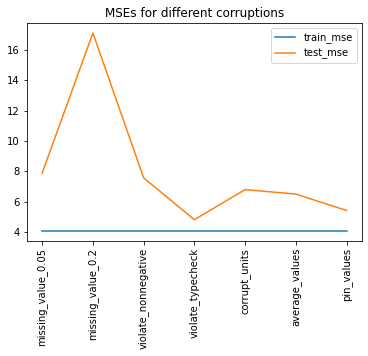

In [14]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame(corruption_results)
# Log results to W&B table
run.log({"corruption_results": wandb.Table(dataframe=results_df)})
plt.plot(results_df["name"], results_df["train_mse"], label="train_mse")
plt.plot(results_df["name"], results_df["test_mse"], label="test_mse")
plt.xticks(rotation=90)
plt.legend()
plt.title("MSEs for different corruptions")
# Log plot to W&B
run.log({"corruption_plot": wandb.Image(plt)})
plt.show()

In [15]:
# We can finish now the W&B run
run.finish()